In [35]:
import pandas as pd
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

### 0. Feature Selection
Deciding which features are truly important for the initial clustering and which will either complement the models or be used to evaluate their own density in the final clusters. 

In [11]:
customer_info = pd.read_csv('../data/raw/clean_customer_info.csv', index_col="customer_id")

In [12]:
customer_info.head()

,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,age
customer_id,,,,,,,,,,,,,,,,,,,
29930,-1.0,1.0,1.0,0.0,0.5,-0.603317,0.350843,0.000000,0.299376,0.717154,0.411301,0.716551,0.629503,-0.301504,0.254423,0.467872,0.867906,0.000000,-0.032258
6813,0.0,-1.0,0.0,-1.0,0.5,-0.514208,-2.423571,0.142857,0.354116,-1.414715,-1.445960,-0.272893,-0.466921,-0.438051,-1.433625,-0.486431,-0.384736,2.460565,0.838710
39451,-1.0,1.0,2.0,-1.0,2.0,-0.014666,0.202372,0.142857,0.790758,0.734816,0.740321,0.473346,0.655227,0.343099,0.048656,-0.729704,0.723964,0.000000,-0.612903
21557,0.0,-1.0,-1.0,0.0,-1.0,-0.141192,0.940175,0.142857,-1.730063,-0.495624,0.733403,0.031924,0.061145,-1.395136,0.751694,-0.220805,0.447107,0.048761,-0.193548
16415,0.0,0.0,0.0,0.0,1.0,0.959008,0.042696,0.142857,-0.350786,0.449038,-0.192228,0.090877,0.475513,0.461414,-1.038064,-1.158433,0.521750,0.192977,0.129032


In [13]:
clustering_customer_info = customer_info.drop(columns=[
    'customer_gender',
    'age',
    'percentage_of_products_bought_promotion',
    'typical_hour',
    'distinct_stores_visited'])

Mainly through the PCA, we were able to see these features were not so relevant when it came to explaining the variability on our data. We should, however, save them for later so that we may analyse their density on the clusters.

### 1. Initial Individual Clustering (Baseline Models)

#### 1.1) Hierarchical Clustering
Hierarchical clustering is an unsupervised learning algorithm that groups data points into clusters based on their similarity, building a tree-like structure of joint groups called a dendrogram. Rather than directly partitioning the dataset into a fixed number of clusters (as K-Means does), hierarchical clustering allows the data to self-organize into progressively more refined clusters, revealing the natural structure present in the data. We then manually select how many clusters should be formed by analysing the dendrogram. One should look for a large "jump" in the graph to decide where we want to draw a line that would define how many clusters we'll chose.

#### Hierarchical Clustering: Advantages and Disadvantages

#### Advantages
- Does not require pre-specifying the number of clusters (dendrogram can guide selection).
- Captures nested clustering structure and hierarchical relationships.
- Works well for small to medium-sized datasets.
- Generates a full hierarchy that can be analyzed at multiple levels of granularity.

#### Disadvantages
- Computationally intensive for large datasets.
- Sensitive to noise and outliers, which may distort the hierarchy.
- May struggle to correctly partition datasets with complex or overlapping cluster structures. **This is the case for our dataset**

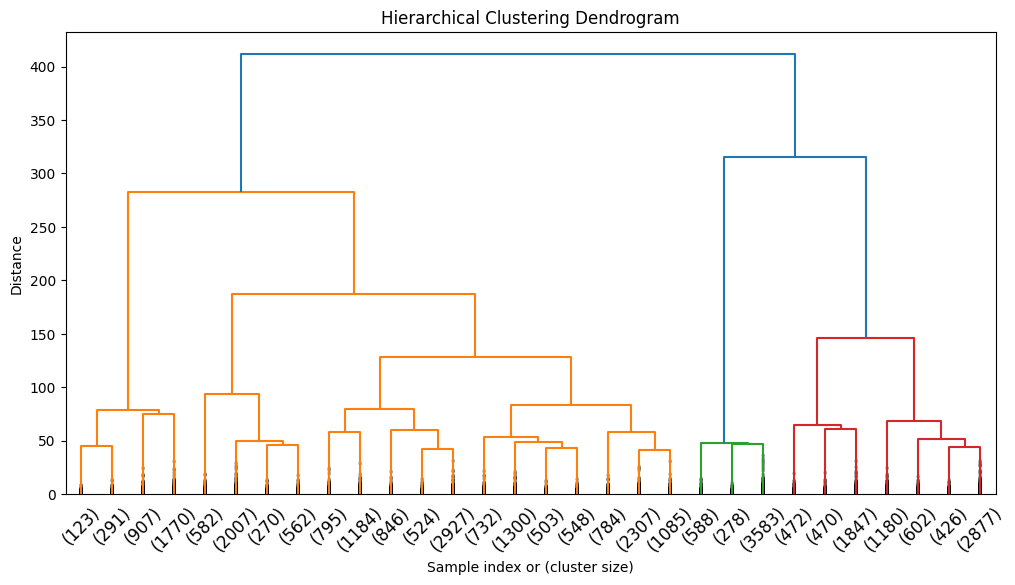

In [14]:
# computing the linkage matrix for dendrogram
linked = linkage(clustering_customer_info, method='ward')  # 'ward' is generally a good default for numeric data

# plotting the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()


The most appropriate division seems to be at about distance 100, where 7 clusters would be formed.

c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


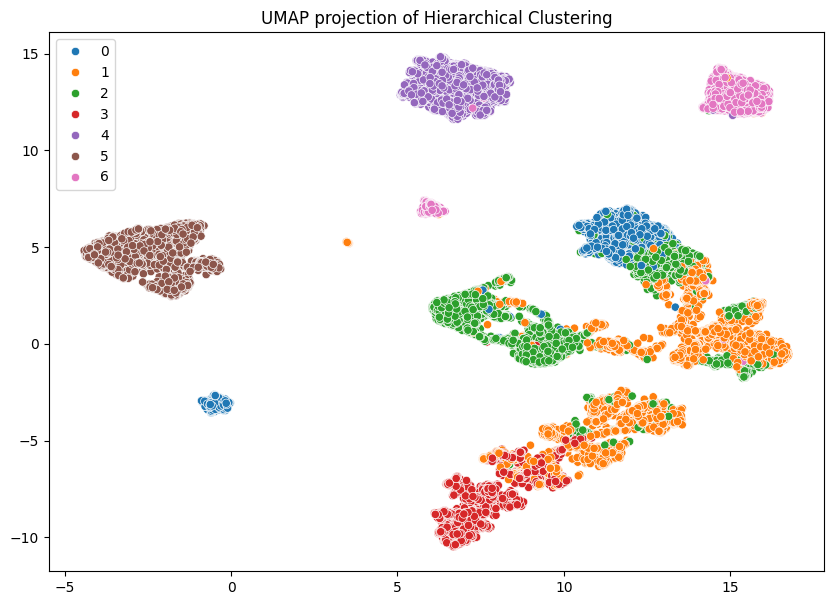

In [15]:
# creating the model
agglo = AgglomerativeClustering(n_clusters=7, linkage='ward')  # you can tune n_clusters
labels = agglo.fit_predict(clustering_customer_info)

# UMAP visualization
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

Not a terrible fit, yet far from good. From simply looking at the data we can see many clusters on the bottom right corner merging with each other, leaving low interpretability. So, let's retry running the model with different numbers of clusters and analyse the results.

c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


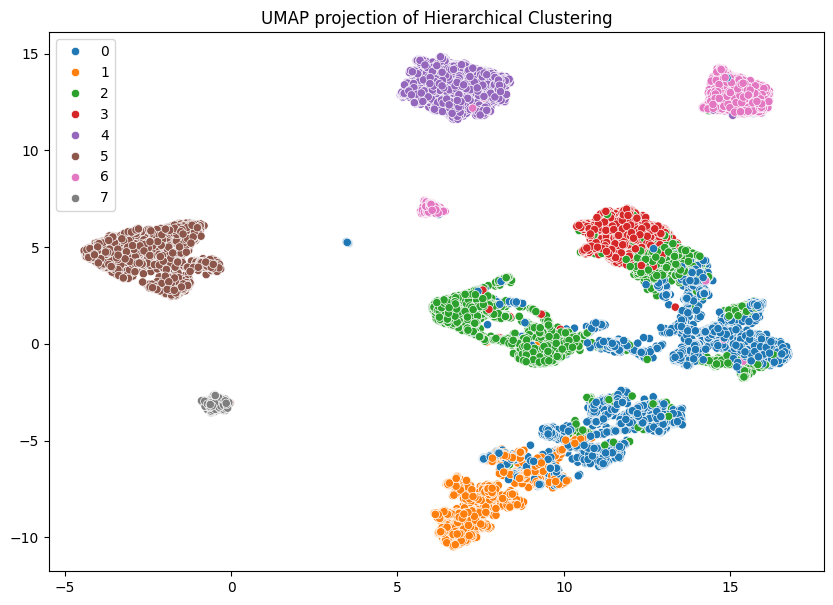

In [16]:
agglo = AgglomerativeClustering(n_clusters=8, linkage='ward')
labels = agglo.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


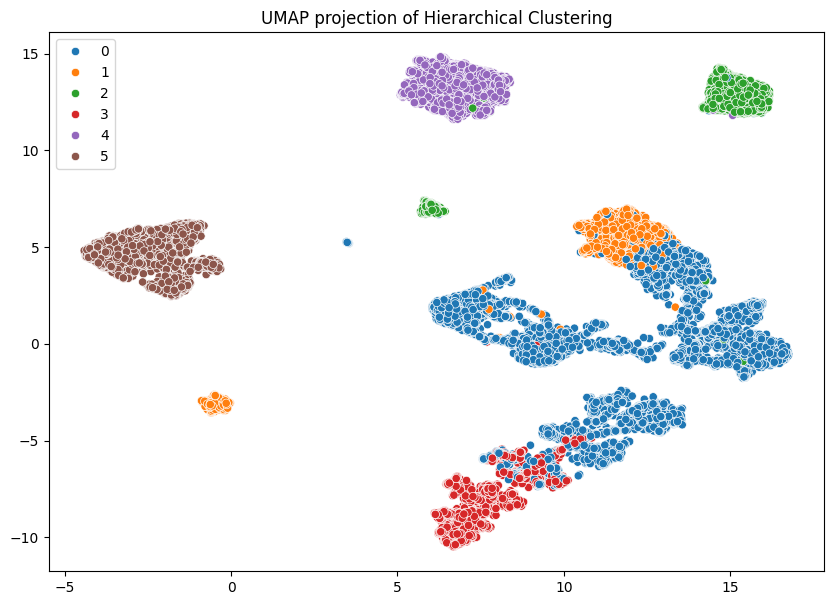

In [17]:
agglo = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels = agglo.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title("UMAP projection of Hierarchical Clustering")
plt.show()

We tested hierarchical clustering with 6, 7, and 8 clusters to balance granularity and interpretability. While increasing the number of clusters allows for finer segmentation, none of the solutions fully captures a clean separation of all groups. The UMAP projections reveal that some clusters remain overlapping or internally heterogeneous across all configurations, suggesting that hierarchical clustering may not be the optimal approach for this dataset.

#### 1.2) K-Means
K-Means divides data into k clusters by minimizing the distance between points and their cluster center. It starts by placing k centroids. Each point is assigned to the nearest centroid. Then, centroids are updated by calculating the average position of all assigned points. This process repeats until centroids stop moving or a maximum number of steps is reached. The goal is to create compact, well-separated groups.

#### K-Means: Advantages and Disadvantages

#### Advantages
- Simple and easy to implement.
- Scales well with the number of observations.
- Works well when clusters are roughly spherical and equally sized.
- Requires few hyperparameters.

#### Disadvantages
- Sensitive to initialization: different runs may yield different results.
- Assumes clusters are spherical and equally sized, struggling with complex shapes. **This is the case for our dataset**
- Sensitive to outliers, which can distort centroids. 

K-Means requires defining the number of clusters k in advance. To help select the optimal k, two metrics are used. The Silhouette Score measures how well-separated and cohesive clusters are, with higher values indicating better structure. The Davies-Bouldin Index compares within-cluster compactness to between-cluster separation, where lower values are preferred. By evaluating both metrics across different values of k, we obtain a more objective basis for choosing the optimal number of clusters.

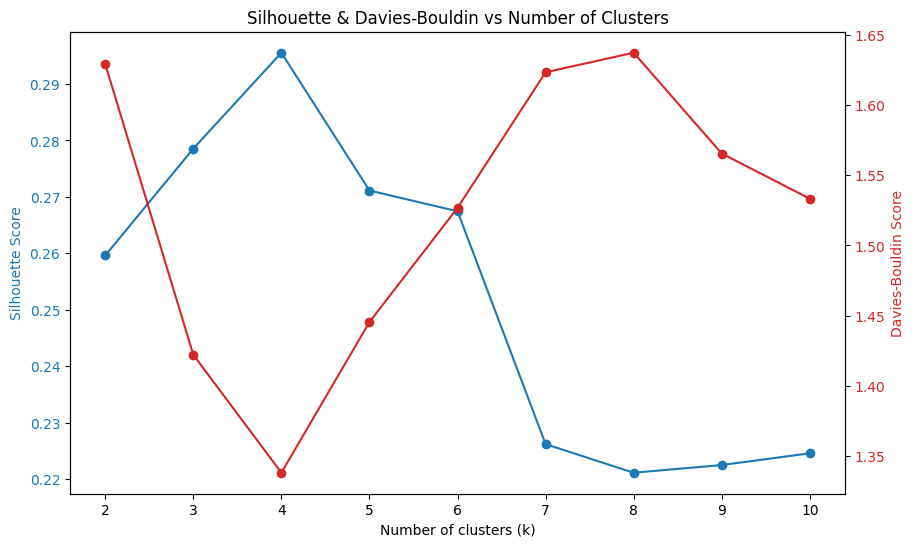

In [ ]:
range_n_clusters = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(clustering_customer_info)
    
    sil_score = silhouette_score(clustering_customer_info, labels)
    db_score = davies_bouldin_score(clustering_customer_info, labels)
    
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)

# plotting both metrics
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(range_n_clusters, silhouette_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Davies-Bouldin Score', color=color)
ax2.plot(range_n_clusters, davies_bouldin_scores, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Silhouette & Davies-Bouldin vs Number of Clusters")
plt.show()


For each tested value of k, K-Means assigns points to clusters. After clustering, the Silhouette Score and Davies-Bouldin Index are calculated. The Silhouette Score averages how well each point fits within its cluster versus the next closest cluster. The Davies-Bouldin Index summarizes cluster compactness and separation. The results are plotted, and the optimal k corresponds to high Silhouette values and low Davies-Bouldin values. It is clear that the point where the Silhouette score is highest while the Davies-Bouldin is lowest is at k=4.

c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


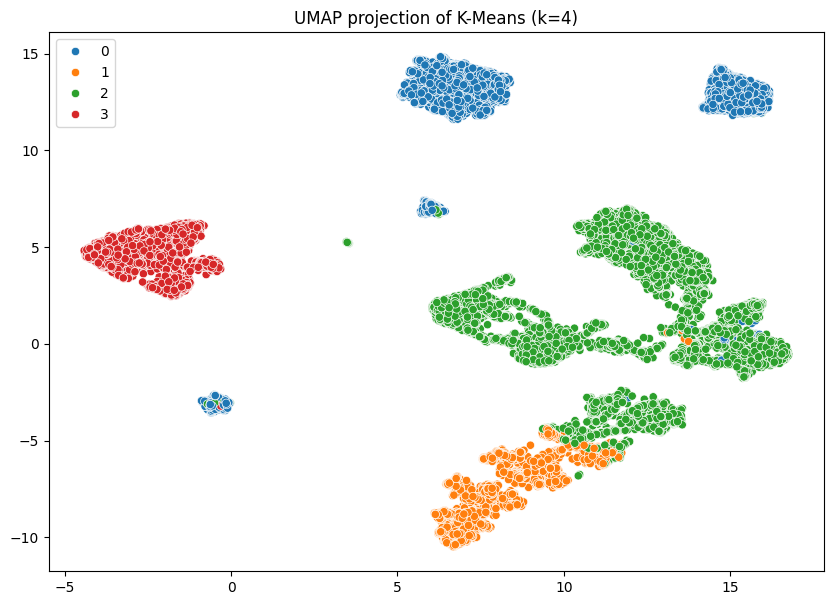

In [36]:
# after inspecting the Silhouette and Davies-Bouldin scores, we can choose the optimal number of clusters.
optimal_k = 4

# fitting the final model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(clustering_customer_info)

# UMAP visualization
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title(f"UMAP projection of K-Means (k={optimal_k})")
plt.show()

The result with k=4 shows some separation, but one cluster remains large and dispersed, grouping several distinct subgroups. This indicates that the solution lacks granularity and may be oversimplifying the true structure. A higher number of clusters could better capture the internal variability of the data, so let's test that.

c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\Documents\GitHub\ML-II-Customer-Segmentation\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


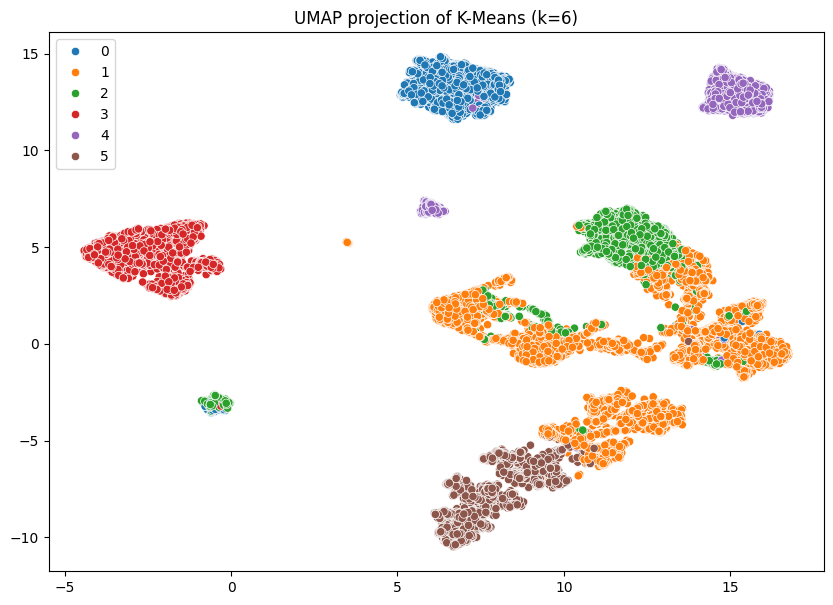

In [37]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(clustering_customer_info)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(clustering_customer_info)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10')
plt.title(f"UMAP projection of K-Means (k={optimal_k})")
plt.show()

Increasing to k=6 does not improve the segmentation. While some minor subgroups are isolated, the overall structure remains similar and part of the large cluster (on the bottom right corner) is still not well separated. Thus, we can conclude that K-Means alone will not suffice as a clustering algorithm for our dataset.

### 2. Tandem Approaches (Two-Step Clustering)

#### 2.1) Hierarchical + K-Means

#### 2.2) K-Means (large k) + Hierarchical

### 3. Comparison, Profiling and Selection